In [2]:
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import lightgbm as lgb
import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor
from math import sqrt



import warnings
warnings.filterwarnings("ignore")

pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

In [3]:
data  = pd.read_csv('../03_Feature_Engineering/v07.csv')
data['roomnights'] = np.where(data.roomnights<0,data.roomnights*-1,data.roomnights)
data['numberofchildren_1'] = np.where(data.numberofchildren==0,1,data.numberofchildren)
data['D_total_room_night'] = data.D_no_days_stay*data.roomnights
data['D_occ_per_room'] = data.total_pax/data.roomnights
data['D_adult_per_room'] = data.numberofadults/data.roomnights
data['D_adult_child_ratio'] = data.numberofadults/data.numberofchildren_1
data['D_person_diff'] = data.total_pax - data.numberofchildren - data.numberofadults
data['D_holiday_ind'] =  np.where(data.D_checkin_week > 51 ,1, 0)
data.drop(columns= ['numberofchildren_1'], inplace = True , axis=1)
data.fillna(0,inplace = True)

In [4]:
train = data[data.tag == "Train"] 
val = data[data.tag == "Val"] 
test = data[data.tag == "Test"] 
train_val = data[data.tag != "Test"] 
train_target = train[['amount_spent_per_room_night_scaled','val_tag']]
val_target = val[['amount_spent_per_room_night_scaled','val_tag']]
train_val_target = train_val[['amount_spent_per_room_night_scaled','val_tag']]

train.shape, val.shape, test.shape, train_val.shape

((272278, 47), (69146, 47), (146765, 47), (341424, 47))

In [5]:
label_cols = ["member_age_buckets", "cluster_code", "reservationstatusid_code", "resort_id"]
for col in label_cols:
    labelencoder = LabelEncoder()
    train[col]= labelencoder.fit_transform(train[col])
    val[col]= labelencoder.transform(val[col])

    labelencoder_full = LabelEncoder()
    train_val[col]= labelencoder_full.fit_transform(train_val[col])
    test[col]= labelencoder_full.transform(test[col])

In [6]:
drop_cols = ['reservation_id','memberid','amount_spent_per_room_night_scaled',
             'tag','checkin_date','booking_date','checkout_date']
train_df = train.drop(columns = drop_cols, axis=1)
val_df = val.drop(columns = drop_cols, axis=1)
train_val_df = train_val.drop(columns = drop_cols, axis=1)
test_df = test.drop(columns = drop_cols, axis=1)

In [7]:
train_df.shape, val_df.shape, test_df.shape, train_val_df.shape

((272278, 40), (69146, 40), (146765, 40), (341424, 40))

In [8]:
cat_cols1 = ['channel_code','main_product_code','persontravellingid','resort_region_code','resort_type_code','room_type_booked_code',
           'season_holidayed_code', 'state_code_residence', 'state_code_resort','member_age_buckets', 'booking_type_code', 'cluster_code',
       'reservationstatusid_code', 'resort_id']

date_cat_cols = ['D_checkin_month','D_checkin_year','D_checkin_week','D_checkin_weekday',
                 'D_booking_month','D_booking_year','D_booking_week','D_booking_weekday',
                 'D_holiday_ind'
                ]

cat_cols = cat_cols1 + date_cat_cols

In [9]:
cat_cols_index = []
count=0
for col in train_df.columns:
    if col in cat_cols:
        cat_cols_index.append(count)
    count+=1
        

In [10]:
folds = 5

params = {'min_data_in_leaf': 35, 'learning_rate': 0.02705919212825226, 'metric': 'rmse', 
 'subsample': 0.9920028820065904, 'bagging_freq': 11, 'importance_type': 'gain',
 'min_sum_hessian_in_leaf': 1, 'verbose': 1, 'boost_from_average': False, 
 'colsample_bytree': 0.13358144268185645, 'objective': 'regression', 
 'max_depth': 3, 'num_leaves': 17, 'verbose_eval': True}



In [11]:
def train_model(X=train_df, X_test=val_df, y=train_target, params=None, folds=folds, model_type='lgb', 
                plot_feature_importance=False, regressor =True, categorical_cols = []):
    print ("Train Data -- >", X.shape[0])
    print ("Test Data -- >", X_test.shape[0])
    
    
    if (regressor==False):
        print ("Classification Probelm--> with {0} classes".format(y.nunique()))
    else:
        print ("Regressor Problem")
        
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    
    X_test.drop(['val_tag'], axis=1, inplace = True)
    X.index = range(0,X.shape[0])
    X_test.index = range(0,X_test.shape[0])
    for fold_n in range(folds):
        print('\nFold', fold_n+1, 'started at', time.ctime())
        X_train, X_valid = X[X.val_tag != fold_n+1], X[X.val_tag == fold_n+1]
        y_train, y_valid = y[y.val_tag != fold_n+1].amount_spent_per_room_night_scaled, y[y.val_tag == fold_n+1].amount_spent_per_room_night_scaled
        valid_index = X_valid.index
        X_train.drop(['val_tag'], axis=1, inplace = True)
        X_valid.drop(['val_tag'], axis=1, inplace = True)
        if model_type == 'lgb':
            if (regressor):
                model = lgb.LGBMRegressor(**params, n_estimators = 20000, nthread = 4, n_jobs = -1)
                model.fit(X_train, y_train, 
                        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                        verbose=1000, early_stopping_rounds=200, categorical_feature =categorical_cols)

                y_pred_valid = model.predict(X_valid)
                y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            else:
                model = lgb.LGBMClassifier(**params, n_estimators = 2000, nthread = 4, n_jobs = -1)
                model.fit(X_train, y_train, 
                        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='logloss',
                        verbose=500, early_stopping_rounds=300)

                y_pred_valid = model.predict_proba(X_valid)[:,1]
                y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:,1]        

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, 
                              early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit)
            
        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.1, 1.0, 10.0, 100.0), scoring='neg_mean_squared_error', cv=3)
            model.fit(X_train, y_train)
            print(model.alpha_)

            y_pred_valid = model.predict(X_valid)
            score = mean_squared_error(y_valid, y_pred_valid) ** 0.5
            print('Fold {0}. RMSE: {1}.'.format(fold_n,score))
            print('')
            
            y_pred = model.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='RMSE', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=categorical_cols, use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_squared_error(y_valid, y_pred_valid) ** 0.5)
        
        prediction += y_pred    
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X_train.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        fp = feature_importance.groupby(['feature'])['importance'].mean().reset_index()
        fp = fp.sort_values(by=['importance'], ascending = False)
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, fp
        return oof, prediction
    
    else:
        return oof, prediction

Train Data -- > 272278
Test Data -- > 69146
Regressor Problem

Fold 1 started at Mon May  6 22:21:00 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.963653	valid_1's rmse: 0.976738
[2000]	training's rmse: 0.956932	valid_1's rmse: 0.974553
[3000]	training's rmse: 0.95293	valid_1's rmse: 0.973966
[4000]	training's rmse: 0.949684	valid_1's rmse: 0.973725
Early stopping, best iteration is:
[4080]	training's rmse: 0.949462	valid_1's rmse: 0.973702

Fold 2 started at Mon May  6 22:21:49 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.965298	valid_1's rmse: 0.97005
[2000]	training's rmse: 0.95848	valid_1's rmse: 0.968243
[3000]	training's rmse: 0.954505	valid_1's rmse: 0.968046
[4000]	training's rmse: 0.951304	valid_1's rmse: 0.967857
Early stopping, best iteration is:
[4160]	training's rmse: 0.950839	valid_1's rmse: 0.967808

Fold 3 started at Mon May  6 22:22:38 2019
Training until validation scores 

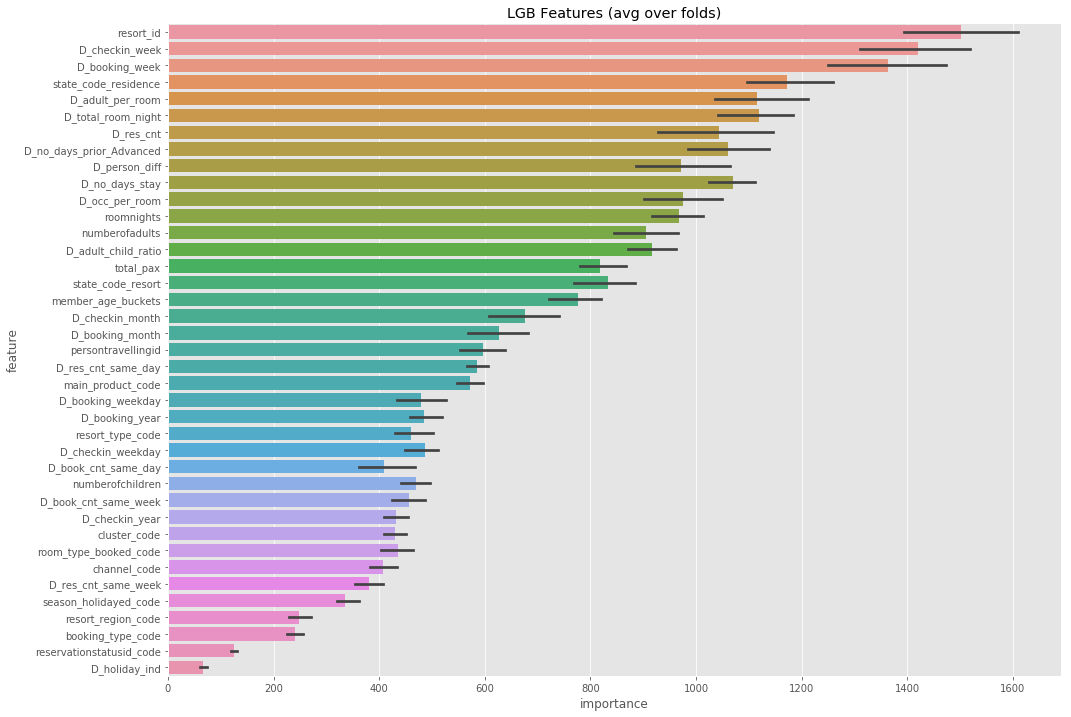

In [12]:
oof, pred, fp = train_model(params=params, model_type='lgb', plot_feature_importance=True, 
                            regressor = True,categorical_cols = cat_cols)

In [16]:
train_analysis = train.copy()
train_analysis['pred'] = oof

val_analysis = val.copy()
val_analysis['pred'] = pred

print ("Train Score : " ,sqrt(mean_squared_error(train_analysis.amount_spent_per_room_night_scaled, train_analysis.pred)))
print ("Val Score : " ,sqrt(mean_squared_error(val_analysis.amount_spent_per_room_night_scaled, val_analysis.pred)))

Train Score :  0.9683121000266809
Val Score :  0.9709637870025982


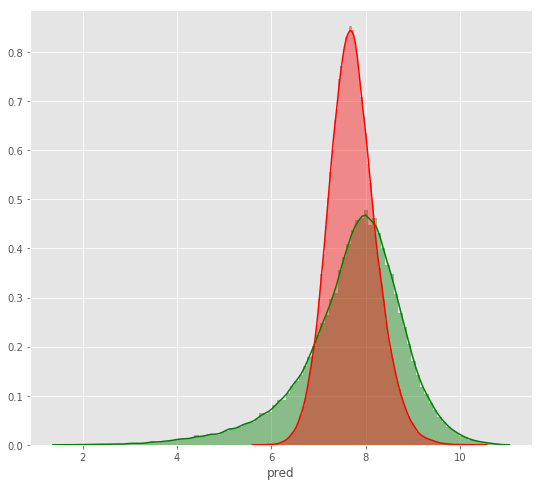

In [17]:
plt.figure(figsize=(9, 8))
sns.distplot(train_analysis['amount_spent_per_room_night_scaled'], color='g', bins=100, hist_kws={'alpha': 0.4});
sns.distplot(train_analysis['pred'], color='r', bins=100, hist_kws={'alpha': 0.4});

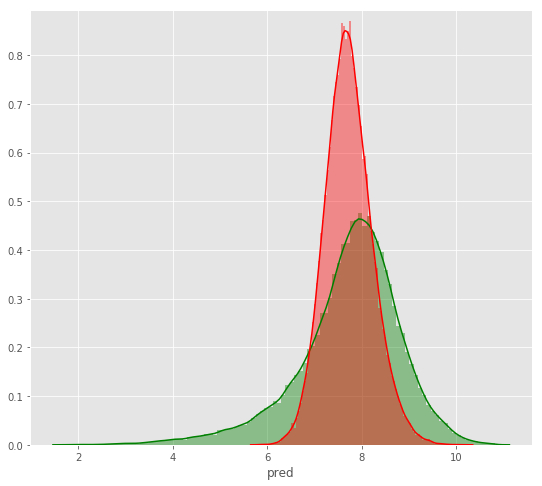

In [18]:
plt.figure(figsize=(9, 8))
sns.distplot(val_analysis['amount_spent_per_room_night_scaled'], color='g', bins=100, hist_kws={'alpha': 0.4});
sns.distplot(val_analysis['pred'], color='r', bins=100, hist_kws={'alpha': 0.4});

In [19]:
train_analysis['error'] = np.abs(train_analysis.amount_spent_per_room_night_scaled - train_analysis.pred)
train_analysis.sort_values(by = ['error'], ascending=False).head(10)

,D_booking_month,D_booking_week,D_booking_weekday,D_booking_year,D_checkin_month,D_checkin_week,D_checkin_weekday,D_checkin_year,D_no_days_prior_Advanced,D_no_days_stay,amount_spent_per_room_night_scaled,booking_date,booking_type_code,channel_code,checkin_date,checkout_date,cluster_code,main_product_code,member_age_buckets,memberid,numberofadults,numberofchildren,persontravellingid,reservation_id,reservationstatusid_code,resort_id,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,tag,total_pax,val_tag,D_res_cnt_same_day,D_book_cnt_same_day,D_res_cnt_same_week,D_book_cnt_same_week,D_res_cnt,D_total_room_night,D_occ_per_room,D_adult_per_room,D_adult_child_ratio,D_person_diff,D_holiday_ind,pred,error
318615,9,38,6,2017,10,40,0,2017,8,2,2.253920,2017-09-24,1,1,2017-10-02,2017-10-04,5,2,5,7afead94f802d1d207694930621a76b374ea70b60644c8993c67ac23cf80b8ad,10,2,45,07c1f40c8e8f8edef7b3f18b0c1c690096733f7385d3e6ec440ce8107c64d36b,2,22,1,1,2,6,2.0,2.0,6,Train,5,4,1,1,1,1,1,12,0.833333,1.666667,5.0,-7,0,8.844267,6.590347
301142,10,44,0,2017,12,52,1,2017,57,3,1.946862,2017-10-30,1,3,2017-12-26,2017-12-29,5,1,5,89fbac19781b43d05d1105cf2abcd0e9eccc9dac55a0af7d5b997ab915a76990,5,0,4753,ef38414c0c6c1d0ff1f23369791292dcca6e7701b6a434adfaeeb37153968aa2,0,5,1,1,3,6,2.0,0.0,6,Train,3,5,1,1,1,1,5,18,0.500000,0.833333,5.0,-2,1,8.488412,6.541550
253728,5,18,3,2018,5,21,5,2018,23,3,1.846353,2018-05-03,1,1,2018-05-26,2018-05-29,5,1,7,69e84731e63fdd21c8ca0030e249a850c633db9453730e54d547acdbc8575264,6,0,45,1a0a34c92d82b52808b49b367cf04d13daf064d785a3256c549ea50ea655897e,0,22,1,1,3,6,1.0,8.0,6,Train,3,2,1,1,1,1,7,18,0.500000,1.000000,6.0,-3,0,8.292769,6.446416
111392,11,44,2,2017,2,7,4,2018,107,2,2.581731,2017-11-01,1,2,2018-02-16,2018-02-18,4,2,4,5a0e525a8f9587d9efbe585c50edbab7a8f59e4d6f1e6c3229c496daf9472536,11,2,45,d4d7d766cc598d07671a1b98139165b263eb0e1752053a97932fe02516534ae9,0,13,1,1,3,8,4.0,1.0,1,Train,4,1,1,1,1,1,5,16,0.500000,1.375000,5.5,-9,0,8.995945,6.414214
152956,3,12,6,2017,5,20,2,2017,52,4,1.609438,2017-03-26,1,1,2017-05-17,2017-05-21,5,1,6,401a27f9857539faa08e458fe29dca243e3acadb09eb0e6330f428b242101347,4,0,45,6ebfb6180cad25002cbdd3703eb2c27984a44357778474deaed0874919ed72d9,0,22,1,1,2,4,1.0,8.0,6,Train,4,2,1,1,2,1,32,16,1.000000,1.000000,4.0,0,0,8.021128,6.411690
333239,4,16,5,2018,5,21,3,2018,33,2,2.302585,2018-04-21,1,1,2018-05-24,2018-05-26,5,1,3,c75da0eab235b152fc8b63ea0a1dbb3d732b29082bc3a808af4b4d121673567b,6,0,45,eca79bbc5ec2a2c594c31ca8497a0835bbff07981762dea7f04e5e83e8a505ad,0,8,3,4,2,4,1.0,12.0,5,Train,7,3,1,1,1,1,2,8,1.750000,1.500000,6.0,1,0,8.555829,6.253244
333488,5,19,2,2018,8,31,2,2018,84,4,1.600397,2018-05-09,1,3,2018-08-01,2018-08-05,5,4,2,e1f536abd301f0f11be8548c98e836a6a3743bf1baadf651cf8befcf7c7f7c63,8,0,45,0fec8e92eee820f2ff9d460996c580b5c569c1b2ac70ca94766441bfc1c48e3d,1,28,1,1,3,12,4.0,1.0,4,Train,5,5,1,1,1,1,1,48,0.416667,0.666667,8.0,-3,0,7.799506,6.199109
305807,5,19,1,2017,5,20,0,2017,6,3,1.609438,2017-05-09,1,1,2017-05-15,2017-05-18,5,2,0,63648bc67c81058d565cb715624379a378ffa13928ce23c17122a1606d789db2,4,0,45,327f082fd8bbc78fcf3bb7de7bed0ab97fbf397fac1df444d68cee2b8d0efb91,1,22,1,1,2,5,1.0,1.0,6,Train,2,1,1,1,1,1,1,15,0.400000,0.800000,4.0,-2,0,7.807026,6.197588
287089,9,35,6,2017,12,51,5,2017,111,4,1.823743,2017-09-03,1,1,2017-12-23,2017-12-27,5,2,7,f43ddc14d33d5ce763d1f59faa6ea18abf20807b1ab9aca6be9faa59731fda52,4,0,45,dd2321de691a3a9efb9adacb5c627a0761170ce9f69ea71589bd2886f331653a,0,5,1,1,2,4,2.0,10.0,6,Train,3,1,1,1,1,1,5,16,0.750000,1.000000,4.0,-1,0,7.964988,6.141245
248521,6,23,3,2018,6,26,1,2018,19,3,1.609438,2018-06-07,1,1,2018-06-26,2018-06-29,5,2,5,033f42d8a29efa22d9c2ca9a40bfaaed275402227e6d254e1702f526aaba7b5e,3,0,4752,99f655cebd67e45ce3c9d8e3af8f10f3bd9ed0664995de7969bd13f2f12f7064,0,27,1,2,3,4,3.0,1.0,11,Train,3,3,1,1,1,1,3,12,0.750000,0.750000,3.0,0,0,7.704809,6.095371


Train Data -- > 341424
Test Data -- > 146765
Regressor Problem

Fold 1 started at Mon May  6 22:27:50 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.970125	valid_1's rmse: 0.980898
[2000]	training's rmse: 0.964364	valid_1's rmse: 0.977056
[3000]	training's rmse: 0.961548	valid_1's rmse: 0.975755
[4000]	training's rmse: 0.959495	valid_1's rmse: 0.975093
[5000]	training's rmse: 0.957862	valid_1's rmse: 0.974684
[6000]	training's rmse: 0.956426	valid_1's rmse: 0.974511
[7000]	training's rmse: 0.955137	valid_1's rmse: 0.974397
[8000]	training's rmse: 0.953955	valid_1's rmse: 0.974288
Early stopping, best iteration is:
[7948]	training's rmse: 0.954012	valid_1's rmse: 0.974281

Fold 2 started at Mon May  6 22:29:38 2019
Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 0.971368	valid_1's rmse: 0.975183
[2000]	training's rmse: 0.965554	valid_1's rmse: 0.971551
[3000]	training's rmse: 0.962895	valid_1's rmse: 0

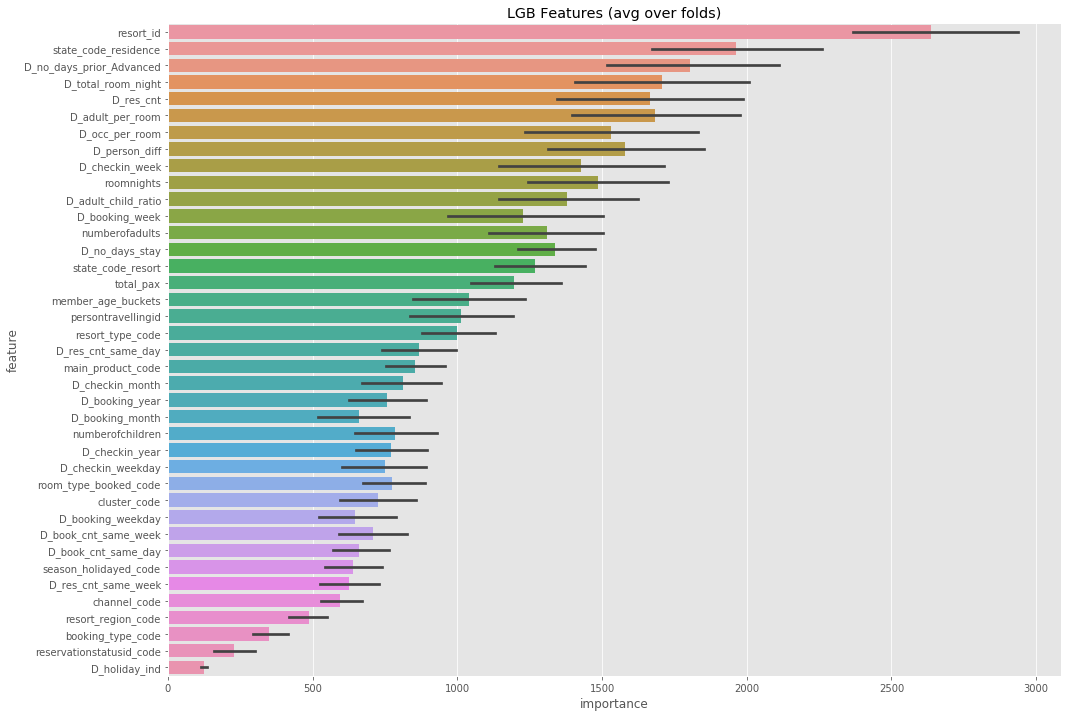

In [20]:
oof_sub, pred_sub, fp_cat = train_model(X=train_val_df, X_test=test_df, y=train_val_target,
                           params=params, model_type='lgb', plot_feature_importance=True, 
                          regressor = True)

In [22]:
train_val_analysis = train_val.copy()
train_val_analysis['pred'] = oof_sub
print ("Val Score : " ,sqrt(mean_squared_error(train_val_analysis.amount_spent_per_room_night_scaled, train_val_analysis.pred)))

Val Score :  0.968340680374044


In [23]:
submission = test[['reservation_id']]
submission['amount_spent_per_room_night_scaled'] = pred_sub
submission.head()

,reservation_id,amount_spent_per_room_night_scaled
341424,7dae1ce6bc8f69481328f2be5c4943077dad5598b5f66d4787cb4596e3086b4f,8.131598
341425,fe0d4e444e1818436c88f72f1cf800536c2f785e59baeb1946e644b405d6233c,7.478354
341426,540bd4285ad8168e8388f84ee74a82cd4f97dc0a404d3e38f40dcb4ce0c4f552,7.584394
341427,09593c907ae262e46f655b4db9e14f54a19eadcfdd26796a33cc98b01c6095c4,7.861679
341428,f4c50caac68051faf37551d70bb17eebef2a20e2244cb1b2d117cd6602737ec1,7.850146


In [24]:
submission.to_csv('../04_Submission/sub20.csv', index = False)